# Logistic Regression

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For our modeling steps
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss

# For demonstrative purposes
from scipy.special import logit, expit
from sklearn import datasets

ModuleNotFoundError: No module named 'numpy.random.bit_generator'

## Objectives

- Describe conceptually the need to move beyond linear regression
- Explain the form of logistic regression
- Explain how to interpret logistic regression coefficients
- Use logistic regression to perform a classification task

[Wikipedia](https://en.wikipedia.org/wiki/Generalized_linear_model) has a nice description of the need to move beyond linear regression for certain sorts of modeling problems.

## Classification

Categorizing compared to regression

### Classic example is image classification: dog or cat? 

![Dog wearing knitted cat hat](images/dog_or_cat.jpg)

> **WARNING**
>
> This doesn't refer to the _degree_ of classification but focuses on how likely they are to be correctly classified (subtle)
> 
> _This email is more spammy than the other, but they're both spam_

### Classification in Data Science

**Classification techniques** are an essential part of machine learning and data mining applications. Most problems in Data Science are classification problems. 

There are lots of classification algorithms that are available, but we'll focus on logistic regression.

We shall focus on binary classification problems, to which logistic regression most immediately applies. Other classification problems handle the cases where multiple classes are present in the target variable.

## Predicting a Categorical Response

Here we have a dataset about glass. Information [here](https://archive.ics.uci.edu/ml/datasets/glass+identification).

## Preparing Data

In [2]:
# glass identification dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
col_names = ['id','ri','na','mg','al','si','k','ca','ba','fe','glass_type']
glass = pd.read_csv(url, names=col_names, index_col='id')
glass.sort_values('al', inplace=True)
glass.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type
id,,,,,,,,,,
22,1.51966,14.77,3.75,0.29,72.02,0.03,9.00,0.0,0.00,1
185,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.0,0.00,6
40,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1
51,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.0,0.16,1


In [3]:
# types 1, 2, 3 are window glass
# types 5, 6, 7 are household glass
glass['household'] = glass.glass_type.map({1:0, 2:0, 3:0, 5:1, 6:1, 7:1})
glass.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,household
id,,,,,,,,,,,
22,1.51966,14.77,3.75,0.29,72.02,0.03,9.00,0.0,0.00,1,0
185,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.0,0.00,6,1
40,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1,0
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1,0
51,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.0,0.16,1,0


Let's change our task, so that we're predicting **household** using **al**. Let's visualize the relationship to figure out how to do this:

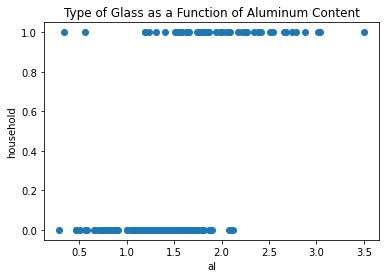

In [4]:
fig, ax = plt.subplots()
ax.scatter(glass.al, glass.household)
ax.set_xlabel('al')
ax.set_ylabel('household')
ax.set_title('Type of Glass as a Function of Aluminum Content');

## Using a Regression Line

Let's draw a **regression line**, like we did before:

In [5]:
# fit a linear regression model and store the predictions

linreg = LinearRegression()
feature_cols = ['al']
X = glass[feature_cols]
y = glass.household
linreg.fit(X, y)
glass['household_pred'] = linreg.predict(X)

NameError: name 'LinearRegression' is not defined

In [ ]:
# scatter plot that includes the regression line

fig, ax = plt.subplots()
ax.scatter(glass.al, glass.household)
ax.plot(glass.al, glass.household_pred, color='red')
ax.set_xlabel('al')
ax.set_ylabel('household');

> What are some issues with this graph?

## Interpreting Our Predictions

If **al=3**, what class do we predict for household? 

If **al=1.5**, what class do we predict for household? 

We predict the 0 class for **lower** values of al, and the 1 class for **higher** values of al. What's our cutoff value? Around **al=2**, because that's where the linear regression line crosses the midpoint between predicting class 0 and class 1.

Therefore, we'll say that if **household_pred >= 0.5**, we predict a class of **1**, else we predict a class of **0**.

## Logistic Regression Formula

Logistic regression can do what we just did.

The strategy now is to *generalize* the notion of linear regression; linear regression as we've known it will become a special case. In particular, we'll keep the idea of the regression best-fit line, but now **we'll allow the model to make predictions through some (non-trivial) transformation of the linear predictor**.

Let's say we've constructed our best-fit line, i.e. our linear predictor, $\hat{L} = \beta_0 + \beta_1x_1 + ... + \beta_nx_n$.

Consider the following transformation: <br/>
$\large\hat{y} = \Large\frac{1}{1 + e^{-\hat{L}}} \large= \Large\frac{1}{1 + e^{-(\beta_0 + ... + \beta_nx_n)}}$. This is called the **sigmoid function**.

We're imagining that $\hat{L}$ can take any values between $-\infty$ and $\infty$.

$\large\rightarrow$ But what values can $\hat{y}$ take? What does this function even look like?

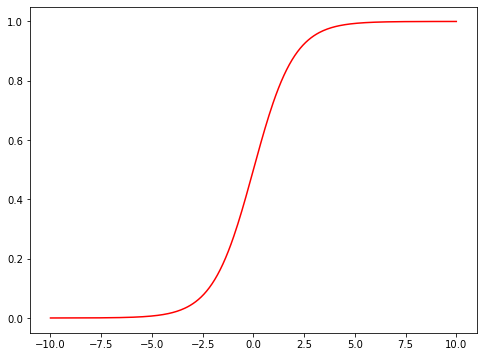

In [12]:
# Let's plot this function here:

X = np.linspace(-10, 10, 300)
Y = 1 / (1 + np.exp(-X))

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(X, Y, 'r');

## Interpretation

This function squeezes our predictions between 0 and 1. And that's why it's so useful for **binary classification problems**.

Suppose I'm building a model to predict whether a plant is poisonous or not, based perhaps on certain biological features of its leaves. I'll let '1' indicate a poisonous plant and '0' indicate a non-poisonous plant.

Now I'm forcing my predictions to be between 0 and 1, so suppose for test plant $P$ I get some value like 0.19.

I can naturally understand this as **the probability that $P$ is poisonous**.

If I truly want a binary prediction, I can simply round my score appropriately.

## Fitting Logistic Regression

### The Logit Function

We just expressed the form of logistic regression in terms of the sigmoid function: **Our model's predictions ($\hat{y}$) are not now identical with the values of the best-fit line but rather with the outputs of the sigmoid function, with those best-fit values passed as input.**

But we can also describe the best-fit line as a function of $\hat{y}$, by applying the **inverse of the sigmoid function** to both sides. This inverse function is called the ***logit* function**:

$ln(\frac{y}{1-y}) = \hat{L} = \beta_0+\beta_1x_1 +...+\beta_nx_n$.

This fraction, $\frac{y}{1-y}$, is the **odds ratio** of y. More on this in the Level-Ups.

Let's try applying the logit function to our target and then fitting a linear regression to that. Since the model will be trained not on whether the glass is household but rather on *the logit of this label*, it will also make predictions of the logit of that label. But we can simply apply the sigmoid function to the model's output to get its predictions of whether the glass is household.

We can't use the target as is, because the logit of 1 is $\infty$ and the logit of 0 is $-\infty$.

In [7]:
glass['household'].unique()

array([0, 1], dtype=int64)

In [8]:
logit(glass['household']).unique()

NameError: name 'logit' is not defined

So we'll make a small adjustment:

In [ ]:
target_approx = np.where(glass['household'] == 0, 1e-9, 1-1e-9)

In [ ]:
line_to_logit = LinearRegression()

X = glass[['al']]
y = logit(target_approx)

In [ ]:
line_to_logit.fit(X, y)

In [ ]:
fig, ax = plt.subplots()

final_preds = expit(line_to_logit.predict(X))
ax.scatter(X, glass['household'])
ax.plot(X, final_preds, 'm');

## `sklearn.linear_model.LogisticRegression()`

In general, we should always scale our data when using this class. Scaling is always important for models that include regularization, and scikit-learn's `LogisticRegression()` objects have regularization by default.

Here we've forgone the scaling since we only have a single predictor.

In [ ]:
# fit a logistic regression model and store the class predictions

logreg = LogisticRegression(random_state=42)
feature_cols = ['al']
X = glass[feature_cols]
y = glass.household
logreg.fit(X, y)
glass['household_pred_class'] = logreg.predict(X)

In [ ]:
# plot the class predictions

fig, ax = plt.subplots()
ax.scatter(glass.al, glass.household)
ax.plot(glass.al, glass.household_pred_class, color='red')
ax.set_xlabel('al')
ax.set_ylabel('household');

## `.predict()` vs. `.predict_proba()`

Let's checkout some specific examples to make predictions with. We'll use both `predict()` and `predict_proba()`.

In [ ]:
glass.al

In [ ]:
# examine some example predictions

print(logreg.predict(glass['al'][22].reshape(1, -1)))
print(logreg.predict(glass['al'][185].reshape(1, -1)))
print(logreg.predict(glass['al'][164].reshape(1, -1)))
print('\n')
print(logreg.predict_proba(glass['al'][22].reshape(1, -1))[0])
print(logreg.predict_proba(glass['al'][185].reshape(1, -1))[0])
print(logreg.predict_proba(glass['al'][164].reshape(1, -1))[0])
first_row = glass['al'][22].reshape(1, -1)

In [ ]:
# store the predicted probabilites of class 1
glass['household_pred_prob'] = logreg.predict_proba(X)[:, 1]

In [ ]:
# plot the predicted probabilities
fig, ax = plt.subplots()
ax.scatter(glass.al, glass.household)
ax.plot(glass.al, glass.household_pred_prob, color='red')
ax.set_xlabel('al')
ax.set_ylabel('household');

## Cost Functions and Solutions To the Optimization Problem

Unlike the least-squares problem for linear regression, no one has yet found a closed-form solution to the optimization problem presented by logistic regression. But even if one exists, the computation would no doubt be so complex that we'd be better off using some sort of approximation method instead.

But there's still a problem.

Recall the cost function for linear regression: <br/><br/>
$SSE = \Sigma_i(y_i - \hat{y}_i)^2 = \Sigma_i(y_i - (\beta_0 + \beta_1x_{i1} + ... + \beta_nx_{in}))^2$.

This function, $SSE(\vec{\beta})$, is convex.

If we plug in our new logistic equation for $\hat{y}$, we get: <br/><br/>
$SSE_{log} = \Sigma_i(y_i - \hat{y}_i)^2 = \Sigma_i\left(y_i - \left(\frac{1}{1+e^{-(\beta_0 + \beta_1x_{i1} + ... + \beta_nx_{in})}}\right)\right)^2$.

### The Bad News

*This* function, $SSE_{log}(\vec{\beta})$, is [**not** convex](https://towardsdatascience.com/why-not-mse-as-a-loss-function-for-logistic-regression-589816b5e03c).

That means that, if we tried to use gradient descent or some other approximation method that looks for the minimum of this function, we could easily find a local rather than a global minimum.

> Note that the scikit-learn class *expects the user to specify the solver* to be used in calculating the coefficients. The default solver, [lbfgs](https://en.wikipedia.org/wiki/Limited-memory_BFGS), works well for many applications.

### The Good News

We can use **log-loss** instead:

$\mathcal{L}(\vec{y}, \hat{\vec{y}}) = -\frac{1}{N}\Sigma^N_{i=1}\left(y_iln(\hat{y}_i)+(1-y_i)ln(1-\hat{y}_i)\right)$,

where $\hat{y}_i$ is the probability that $(x_{i1}, ... , x_{in})$ belongs to **class 1**.

## Log Loss

The first column of the return on our `predict_proba()` method indicates the predicted probability of **class 0**, and the second column indicates the predicted probability of **class 1**.

In [ ]:
log_loss(glass.household, logreg.predict_proba(X)[:, 1])

### Verifying by Hand

In [ ]:
y_hat = logreg.predict_proba(X)[:, 1]

-np.mean([y*np.log(y_hat) + (1-y)*np.log(1-y_hat)])

The above is a pretty good score. A baseline classifier that is fit on data with equal numbers of data points in the two target classes should be right about 50% of the time, and the log loss for such a classifier would be $-ln(0.5) = 0.693$.

In [ ]:
-np.log(0.5)

**More resources on the log-loss function**:

https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-ii-d20a239cde11

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

### 🧠 Knowledge Check

- Is a bigger value (more positive) better or worse than a smaller value?

- What would the log-loss for one data point when the target is $0$ but we predict $1$?

- What would the log-loss for one data point when the target is $0$ but we predict $0$?

## Putting It All Together: Training Logistic Regression

Let's take some time to show how you can do use logistic regression in practice.

> Note we've been talking about _binary classification_ but we can also do classification for _multiclass_ problems (more than binary classes).
>
> That's what we'll do for this example.

### Load and Explore Data

In [13]:
# Built in dataset from sklearn
iris = datasets.load_iris()

df = pd.DataFrame(
    data=np.c_[iris['data'], iris['target']],
    columns=iris['feature_names'] + ['target']
)

display(df.head())
display(df.describe())

NameError: name 'datasets' is not defined

In [ ]:
# Note how many different targets there are
df.target.unique()

We can go ahead and explore some graphs to show that it doesn't make sense to do a linear regression

In [ ]:
# Creating a large figure
fig = plt.figure(figsize=(15, 8))

# Iterating over the different
for i in range(0, 4):
    # Figure number starts at 1
    ax = fig.add_subplot(2, 2, i+1)
    # Add a title to make it clear what each subplot shows
    plt.title(df.columns[i])
    # Use alpha to better see crossing pints
    ax.scatter(df['target'], df.iloc[:, i], c='teal', alpha=0.1)
    # Only show the tick marks for each target
    plt.xticks(df.target.unique())

Preparing the data for classification

In [ ]:
# Get the features and then the target
X = df.iloc[:, :-1]
y = df.target

In [ ]:
# Normalize the data to help the model
X = normalize(X)
X

In [ ]:
# Now each row vector has unit length
sum([x**2 for x in X[0, :]])

In [ ]:
# Split for test & training  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

### Create and Train Logistic Regression Model

There's a lot of different parameters for `LogisticRegression`. Check out the documentation for more info: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
my_model = LogisticRegression(
            C=1e3,             # Smaller values -> more regularization
            max_iter=1e3,      # Ensure we eventually reach a solution
            solver='lbfgs',    # (Default) Can optimize depending on problem
            multi_class='ovr'  # (Default) Will try to do multiclass classification 
)

In [ ]:
# Fit/Train the model
my_model.fit(X_train, y_train)
my_model

### Optional: Evaluate the Model with Cross-Validation

In practice, we should make this a practice but we skip it if time is running low

In [ ]:
cv_results = cross_validate(
                    estimator=my_model,
                    X=X_train,
                    y=y_train,
                    cv=5,
                    return_train_score=True
)

In [ ]:
cv_results['train_score']

In [ ]:
cv_results['test_score']

In [ ]:
def cv_overall(cv_results):
    val_results = cv_results['test_score']
    result_str = f'{val_results.mean():.3f} ± {val_results.std():.3f}'
    return result_str

In [ ]:
cv_overall(cv_results)

In [ ]:
# Let's save these results for later
models = {}

models['model_1'] = {'model': my_model, 'cv':cv_results}

In [ ]:
# Overall Training Score
my_model.score(X_train,y_train)

### Optional: Rinse and Repeat - Multiple Models

Let's try out a few more models for fun

In [ ]:
# Adjust the regularization C
c_values = [1e-1, 1e2, 1e4, 1e6]

# Start at #2 since we have "model_1" already
for i, c in enumerate(c_values, start=2):
    
    print(f'Model #{i} with C={c}')
    new_model = LogisticRegression(C=c, max_iter=1e3)
    
    # Cross-validation
    print('Cross-validating model with training data...')
    cv_results = cross_validate(
                    estimator=new_model,
                    X=X_train,
                    y=y_train,
                    cv=5,
                    return_train_score=True
    )
    print(f'\tCross-Validation Score: {cv_overall(cv_results)}')
    
    # Train/fit with the full training set
    print('Fitting model to full training set...')
    new_model.fit(X_train, y_train)
    train_score = new_model.score(X_train, y_train)
    print(f'\tScore on training set: {train_score:.3f}')
    
    # Save results
    print('Saving Results...')
    models[f'model_{i}'] = {'model': new_model, 'cv': cv_results}
    
    print('\n','-'*30,'\n')

## Final Evaluation

In [ ]:
best_model = models['model_5']['model']
best_model

In [ ]:
# Let's get predictions for training & testing sets
y_hat_train = best_model.predict(X_train)
y_hat_test = best_model.predict(X_test)

### Log-Loss on Best Model

In [ ]:
print(log_loss(y_train, best_model.predict_proba(X_train)))
print(log_loss(y_test, best_model.predict_proba(X_test)))

### Training Set

In [ ]:
# Was our model correct?
residuals = y_train == y_hat_train

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

print('\n','-'*30,'\n')

print('Percentage of values correctly predicted: ')
print(pd.Series(residuals).value_counts(normalize=True))

### Testing Set

In [ ]:
residuals = y_test == y_hat_test

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

print('\n','-'*30,'\n')

print('Percentage of values correctly predicted: ')
print(pd.Series(residuals).value_counts(normalize=True))

## Exercise

Split the data below into train and test, and then convert the y-values (`geysers.kind`) into 1's and 0's. Then use `sklearn` to build a logistic regression model of whether Old Faithful's eruption wait time is long or short, based on the duration of the eruption. Finally, find the points in the test set where the model's prediction differs from the true y-value. How many are there?

In [ ]:
geysers = sns.load_dataset('geyser', **{'usecols': ['duration', 'kind']})

In [ ]:
geysers.head()

# Level Ups

## Level Up: Odds

There are other ways to squeeze the results of a linear regression into the set (0, 1).

But the ratio $\frac{p}{1-p}$ represents the *odds* of some event, where $p$ is the probability of the event.

$$probability = \frac {one\ outcome} {all\ outcomes}$$

$$odds = \frac {one\ outcome} {all\ other\ outcomes}$$

Examples:

- Dice roll of 1: probability = 1/6, odds = 1/5
- Even dice roll: probability = 3/6, odds = 3/3 = 1
- Dice roll less than 5: probability = 4/6, odds = 4/2 = 2

$$odds = \frac {probability} {1 - probability}$$

$$probability = \frac {odds} {1 + odds}$$

And so the logit function represents the **log-odds** of success (y=1).

## Level Up: Interpreting Logistic Regression Coefficients

In [ ]:
logreg.coef_

How do we interpret the coefficients of a logistic regression? For a linear regression, the situaton was like this:

- Linear Regression: We construct the best-fit line and get a set of coefficients. Suppose $\beta_1 = k$. In that case we would expect a 1-unit change in $x_1$ to produce a $k$-unit change in $y$.

- Logistic Regression: We find the coefficients of the best-fit line by some approximation method. Suppose $\beta_1 = k$. In that case we would expect a 1-unit change in $x_1$ to produce a $k$-unit change (not in $y$ but) in $ln\left(\frac{y}{1-y}\right)$.

We have:

$\ln\left(\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)}\right) = \ln\left(\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}\right) + k$.

Exponentiating both sides:

$\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)} = e^{\ln\left(\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}\right) + k}$ <br/><br/> $\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)}= e^{\ln\left(\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}\right)}\cdot e^k$ <br/><br/> $\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)}= e^k\cdot\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}$

That is, the odds ratio at $x_1+1$ has increased by a factor of $e^k$ relative to the odds ratio at $x_1$.

For more on interpretation, see [this page](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/binary-logistic-regression/interpret-the-results/all-statistics-and-graphs/coefficients/).

In [ ]:
# examine the intercept

logreg.intercept_

**Interpretation:** For an 'al' value of 0, the log-odds of 'household' is -6.01. What is the probability that glass with an 'al' value of 0 is household glass?

In [ ]:
# convert log-odds to probability

logodds = logreg.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob

In [ ]:
# examine the coefficient for al

list(zip(feature_cols, logreg.coef_[0]))

**Interpretation:** A 1 unit increase in 'al' is associated with a 3.12-unit increase in the log-odds of 'household'.

##### Aside: Verifying log-odds to probability

Let's verify this as we change the aluminum content from 1 to 2.

In [ ]:
# Prediction for al=1

pred_al1 = logreg.predict_proba([[1]])
pred_al1

In [ ]:
# Odds ratio for al=1

odds_al1 = pred_al1[0][1] / pred_al1[0][0]
odds_al1

In [ ]:
# Prediction for al=2
pred_al2 = logreg.predict_proba([[2]])
pred_al2

In [ ]:
# Odds ratio for al=2

odds_al2 = pred_al2[0][1] / pred_al2[0][0]
odds_al2

print((np.exp(logreg.coef_[0]) * odds_al1)[0])
print(odds_al2)

##### Aside: Use Coefficients to Generate Prediction

In [ ]:
# compute predicted log-odds for al=2 using the equation
x_al = 2
logodds = logreg.intercept_ + logreg.coef_[0] * x_al
logodds

In [ ]:
# convert log-odds to odds

odds = np.exp(logodds)
odds

In [ ]:
# convert odds to probability

prob = odds / (1 + odds)
prob

In [ ]:
# compute predicted probability for al=2 using the predict_proba method

logreg.predict_proba(np.array([2.0]).reshape(1, 1))[:, 1]

## More Generalizations: Other Link Functions, Other Models

Logistic regression's link function is the logit function, but different sorts of models use different link functions.

[Wikipedia](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function) has a nice table of generalized linear model types and their associated link functions.